# Introduction

In this notebook, I will create a decision tree classifier from scratch using pandas and numpy libraries. Then, I will use the iris dataset to test my model against the scikit-learn built-in decision tree classifier. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
from pprint import pprint

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iris/Iris.csv
/kaggle/input/iris/database.sqlite


# Preprocessing

**Modify the Columns**

To better assist my development, I will drop the Id column, which doesn't have any useful information for the decision tree, and change the column name Species to label.

In [2]:
full_data = pd.read_csv('/kaggle/input/iris/Iris.csv')
full_data = full_data.drop('Id', axis=1)
full_data = full_data.rename(columns={"Species": "label"})

full_data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


**Null Values**

Another thing I need to check is the null values in the dataset. Luckily in this dataset there is no null value.

In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   label          150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


**Train Test Split**

This helper method will create the train and test set for evaluation

In [4]:
def train_test_split(df, test_size):
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))
    
    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)
    
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [5]:
random.seed(0)
train_data, test_data = train_test_split(full_data, 0.25)

**Data Visualization**

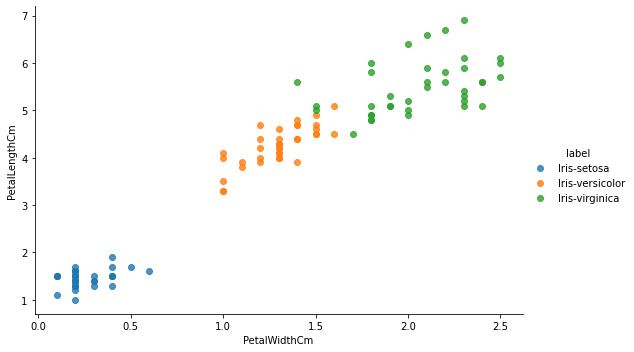

In [6]:
sns.lmplot(data=train_data, x='PetalWidthCm', y='PetalLengthCm', fit_reg=False, hue='label', height=5, aspect=1.5)

# Helper Functions

This section will contain all the helper functions I will use to create my decision tree classifier. The idea of a decision tree is that on every node, the tree will split the data in a way that the two splitted dataset will have lowest entropy(meaning the data will be the purest) and finally predict the class of leaves. To achieve this, I need to first create some helper methods:

* Check Purity: check if the data is now pure(having only one kind of label)
* Predict Class: predict the class of current leaf(return which label is most frequent)
* Get Potential Splits: get all the potential splits(every split inbetween every value for every column)
* Get Best Split: get the best split that leads to the lowest entropy
* Calculate Entropy: calculate the entropy

**Check Purity**

This helper function will determine if the data in this node are pure, which means if they all belong to the same class.

In [7]:
def check_purity(data):
    label_col = data[:, -1]
    return len(np.unique(label_col)) == 1

*Test*

In [8]:
check_purity(train_data[train_data.PetalWidthCm < 0.8].values)

True

In [9]:
check_purity(train_data[train_data.PetalWidthCm > 0.8].values)

False

**Preidct Class**

This helper function will predict the label of this leaf based on the most frequent label

In [10]:
def predict_class(data):
    label_col = data[:, -1]
    classes, counts = np.unique(label_col,return_counts=True)
    
    return classes[np.argmax(counts)]

*Test*

In [11]:
predict_class(train_data[train_data.PetalWidthCm < 0.8].values)

'Iris-setosa'

In [12]:
predict_class(train_data[(train_data.PetalWidthCm > 0.8) & (train_data.PetalWidthCm < 2)].values)

'Iris-versicolor'

In [13]:
predict_class(train_data[train_data.PetalWidthCm > 1.2].values)

'Iris-virginica'

**Get Potential Splits**

This helper function will return all the possible splits for this tree. The possible splits are spliting between all the intervals between adjacent values in each column

In [14]:
def get_potential_splits(data):
    potential_splits = {}
    
    columns = data.shape[1]
    for col in range(columns-1):
        potential_splits[col] = []
        
        values = data[:, col]
        unique_values = np.unique(values)
        
        for index in range(len(unique_values)):
            if index != 0:
                cur_value = unique_values[index]
                pre_value = unique_values[index - 1]
                
                potential_split = (cur_value + pre_value) / 2
                potential_splits[col].append(potential_split)
    
    return potential_splits

*Test*

In [15]:
potential_splits = get_potential_splits(train_data.values)

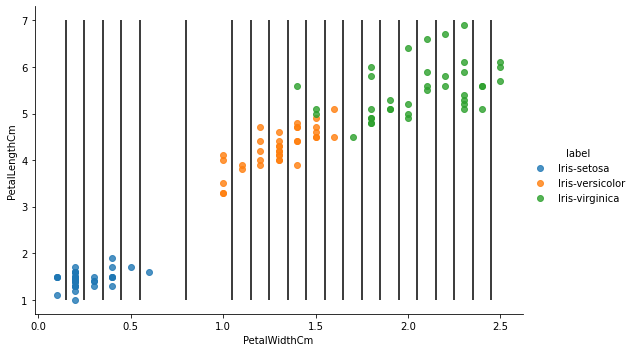

In [16]:
sns.lmplot(data=train_data, x='PetalWidthCm', y='PetalLengthCm', fit_reg=False, hue='label', height=5, aspect=1.5)

plt.vlines(x=potential_splits[3], ymin=1, ymax=7)

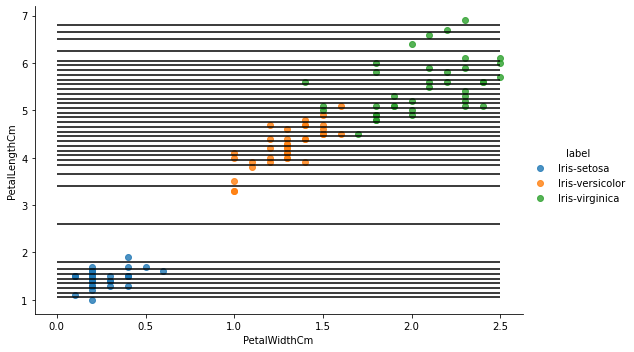

In [17]:
sns.lmplot(data=train_data, x='PetalWidthCm', y='PetalLengthCm', fit_reg=False, hue='label', height=5, aspect=1.5)

plt.hlines(y=potential_splits[2], xmin=0, xmax=2.5)

**Split Data**

This helper function will split the data based on the column to split and value to split and return the two subtrees

In [18]:
def split_data(data, split_column, split_value):
    split_column_values = data[:, split_column]
    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values > split_value]
    
    return data_below, data_above

*Test*

In [19]:
data_below, data_above = split_data(train_data.values, 3, 0.8)

(0.0, 2.6)

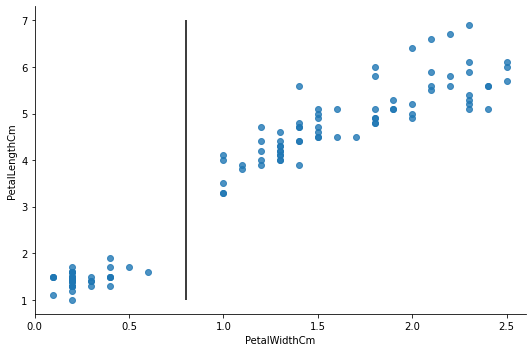

In [20]:
plotting_data = pd.DataFrame(train_data, columns=train_data.columns)

sns.lmplot(data=plotting_data, x='PetalWidthCm', y='PetalLengthCm', fit_reg=False, height=5, aspect=1.5)

plt.vlines(x=0.8, ymin=1, ymax=7)
plt.xlim(0, 2.6)

(0.0, 2.6)

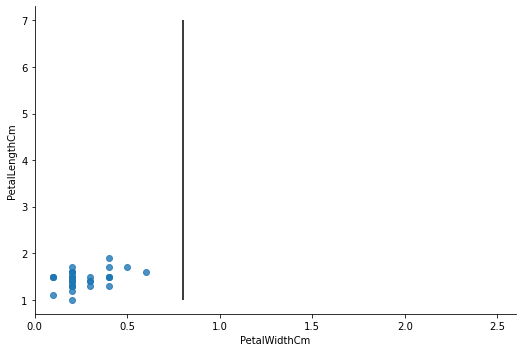

In [21]:
plotting_data = pd.DataFrame(data_below, columns=train_data.columns)

sns.lmplot(data=plotting_data, x='PetalWidthCm', y='PetalLengthCm', fit_reg=False, height=5, aspect=1.5)

plt.vlines(x=0.8, ymin=1, ymax=7)
plt.xlim(0, 2.6)

(0.0, 2.6)

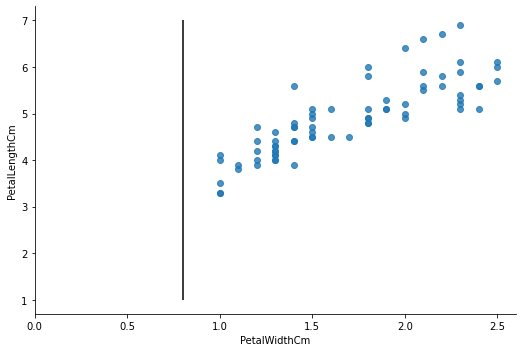

In [22]:
plotting_data = pd.DataFrame(data_above, columns=train_data.columns)

sns.lmplot(data=plotting_data, x='PetalWidthCm', y='PetalLengthCm', fit_reg=False, height=5, aspect=1.5)

plt.vlines(x=0.8, ymin=1, ymax=7)
plt.xlim(0, 2.6)

**Calculate Entropy**

This helper function will calculate the entropy of current node. 

In [23]:
def calculate_entropy(data):
    label_col = data[:, -1]
    counts = np.unique(label_col, return_counts=True)[1]
    
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    
    return entropy

*Test*

In [24]:
calculate_entropy(data_below)

0.0

In [25]:
calculate_entropy(data_above)

0.9987813930727558

**Calculate Overall Entropy**

This helper function will calculate the overall entropy of the two subnodes of a node

In [26]:
def calculate_overall_entropy(data_below, data_above):
    n_data_points = len(data_below) + len(data_above)
    
    p_data_below = len(data_below) / n_data_points
    p_data_above = len(data_above) / n_data_points
    
    overall_entropy = (p_data_below * calculate_entropy(data_below)) + (p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

*Test*

In [27]:
calculate_overall_entropy(data_below, data_above)

0.6509914436992069

**Determin Best Split**

This helper function will determine the best split of a node based on all potential splits. The best split is the one that leads to the lowest overall entropy of the two subnodes.

In [28]:
def determine_best_split(data, potential_splits):
    overall_entropy = 999
    potential_splits = get_potential_splits(data)
    
    for col in potential_splits:
        for val in potential_splits[col]:
            data_below, data_above = split_data(data, split_column=col, split_value=val)
            temp_entropy = calculate_overall_entropy(data_below, data_above)
            
            if temp_entropy <= overall_entropy:
                overall_entropy = temp_entropy
                best_split_col = col
                best_split_val = val
                
    return best_split_col, best_split_val

*Test*

In [29]:
determine_best_split(train_data.values, get_potential_splits(train_data.values))

(3, 0.8)

# Main Algorithm

In this section, I will combine all the helper functions to create the final decision tree model. Specifically, I will make a recursive decision tree algorithm that will split the data based on best split until at least one of the three following conditions is met:

* All samples on the leaf are belong to the same class
* the leaf has only 2 or less samples
* the depth of the tree is 5

If one of these condition is met, the algorithm will predict the class based on the most frequent class label on the leaf

In [30]:
def decision_tree_algo(df, depth=0, min_samples_leaf=2, max_depth=5):
    if depth == 0:
        global col_headers
        data = df.values
        col_headers = df.columns
    else:
        data = df
    
    if (check_purity(data)) or (len(data) < min_samples_leaf) or (depth == max_depth):
        return predict_class(data)
    else:
        depth += 1
        
        potential_splits = get_potential_splits(data)
        split_col, split_val = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_col, split_val)
        
        feature_name = col_headers[split_col]
        question = "{} <= {}".format(feature_name, split_val)
        sub_tree = {question: []}
        
        yes_answer = decision_tree_algo(data_below, depth, min_samples_leaf, max_depth)
        no_answer = decision_tree_algo(data_above, depth, min_samples_leaf, max_depth)
        
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
            
        return sub_tree

*Test*

In [31]:
tree = decision_tree_algo(train_data, min_samples_leaf=2, max_depth=3)
pprint(tree)

{'PetalWidthCm <= 0.8': ['Iris-setosa',
                         {'PetalWidthCm <= 1.65': [{'PetalLengthCm <= 4.95': ['Iris-versicolor',
                                                                              'Iris-virginica']},
                                                   'Iris-virginica']}]}


# Classification

In [32]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, operator, value = question.split()
    
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]
        
    if not isinstance(answer, dict):
        return answer
    else:
        return classify_example(example, answer)

In [33]:
example = test_data.iloc[0]
example

SepalLengthCm                5.1
SepalWidthCm                 2.5
PetalLengthCm                  3
PetalWidthCm                 1.1
label            Iris-versicolor
Name: 98, dtype: object

In [34]:
classify_example(example, tree)

'Iris-versicolor'

In [35]:
example2 = test_data.iloc[15]
example2

SepalLengthCm            4.8
SepalWidthCm             3.4
PetalLengthCm            1.9
PetalWidthCm             0.2
label            Iris-setosa
Name: 24, dtype: object

In [36]:
classify_example(example2, tree)

'Iris-setosa'

# Accuracy

The accuracy shows that our decision tree model has the exact same test set accuracy as the sci-kit learn built-in decision tree model, which shows that our implementation is successful.

In [37]:
def calculate_accuracy(df, tree):
    df['prediction'] = df.apply(classify_example, axis=1, args=(tree,))
    df['prediction_correct'] = df.prediction == df.label
    
    accuracy = df.prediction_correct.mean()
    return accuracy

In [38]:
calculate_accuracy(test_data, tree)

0.9473684210526315

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


test_data = test_data.drop(['prediction', 'prediction_correct'], axis=1)

decision_model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, max_depth=3)
decision_model.fit(train_data.drop('label', axis=1), train_data['label'])

y_pred = decision_model.predict(test_data.drop('label', axis=1))
print(accuracy_score(test_data['label'], y_pred))

0.9473684210526315


# Tree Model

In this section I compare the structure of our decision tree and the scikit-learn decision tree. The two shows that our model learns the exact same splits as the sci-kit learn decision tree.

In [40]:
pprint(tree)

{'PetalWidthCm <= 0.8': ['Iris-setosa',
                         {'PetalWidthCm <= 1.65': [{'PetalLengthCm <= 4.95': ['Iris-versicolor',
                                                                              'Iris-virginica']},
                                                   'Iris-virginica']}]}


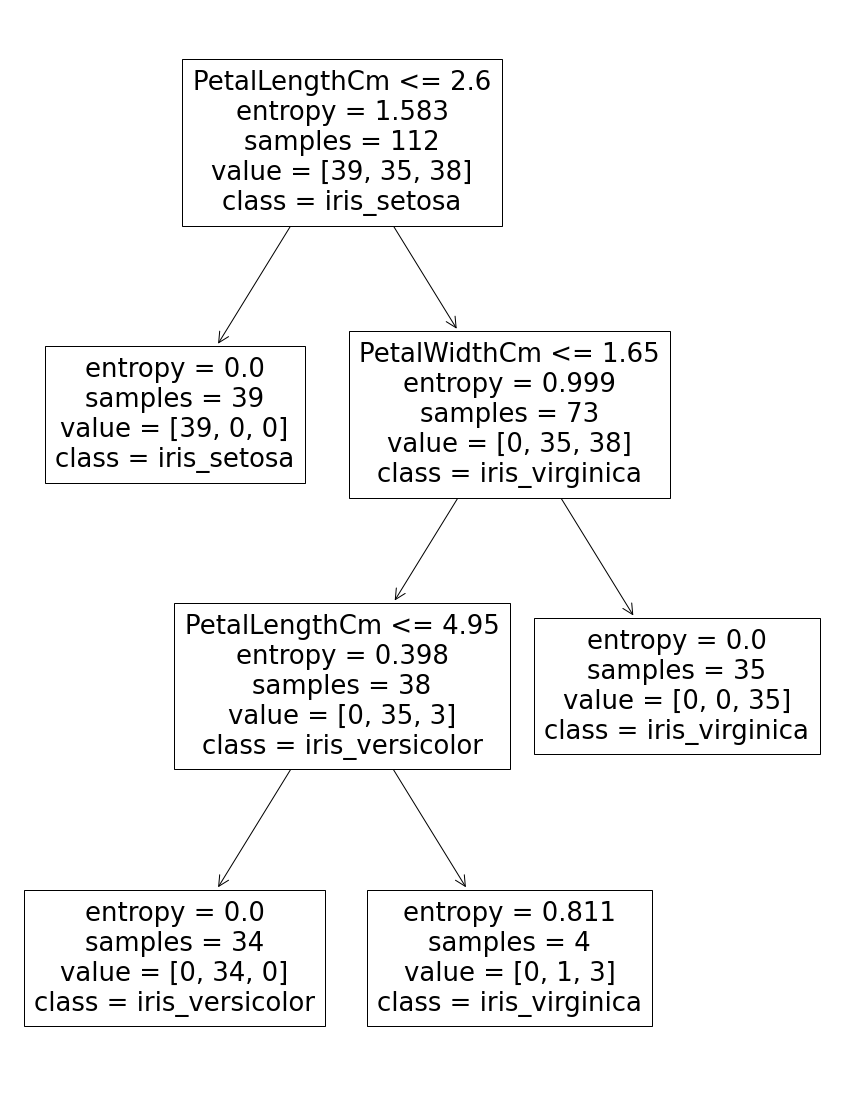

In [41]:
from sklearn import tree

plt.figure(figsize=(15,20))
tree.plot_tree(decision_model, feature_names=test_data.drop('label', axis=1).columns, class_names=('iris_setosa', 'iris_versicolor', 'iris_virginica'))
plt.show()